<a href="https://colab.research.google.com/github/Ruchi765/Assignment/blob/main/DeFi_Wallet_Credit_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import json

In [65]:
uploaded = "/content/user-wallet-transactions.json"

In [66]:
# Load JSON file
def load_data(filename):
    with open(filename) as f:
        data = json.load(f)
        return pd.json_normalize(data)

In [67]:
# Convert amount and price fields to float
def parse_float(val):
    try:
        return float(val)
    except:
        return 0.0

df['amount'] = df['actionData.amount'].apply(parse_float)
df['price_usd'] = df['actionData.assetPriceUSD'].apply(parse_float)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['usd_value'] = df['amount'] * df['price_usd']


In [68]:
# Inspect data structure
print(df.info())
print("\nAction Counts:")
print(df['action'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   userWallet                          100000 non-null  object        
 1   network                             100000 non-null  object        
 2   protocol                            100000 non-null  object        
 3   txHash                              100000 non-null  object        
 4   logId                               100000 non-null  object        
 5   timestamp                           100000 non-null  datetime64[ns]
 6   blockNumber                         100000 non-null  int64         
 7   action                              100000 non-null  object        
 8   __v                                 100000 non-null  int64         
 9   _id.$oid                            100000 non-null  object        
 10  actionDat

In [69]:
def engineer_features(df):
    # Ensure timestamp is in datetime format, assuming it's currently in seconds if not already
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    df['actionData.principalAmount'] = pd.to_numeric(df['actionData.principalAmount'], errors='coerce')

    grp = df.groupby('userWallet')

    feats = pd.DataFrame({
        'tx_count': grp.size(),
        'n_deposit': grp['action'].apply(lambda x: (x=='deposit').sum()),
        'n_borrow': grp['action'].apply(lambda x: (x=='borrow').sum()),
        'n_repay': grp['action'].apply(lambda x: (x=='repay').sum()),
        'n_redeem': grp['action'].apply(lambda x: (x=='redeemunderlying').sum()),
        'n_liq': grp['action'].apply(lambda x: (x=='liquidationcall').sum()),
        'amt_avg': grp['actionData.principalAmount'].mean(),
        'amt_max': grp['actionData.principalAmount'].max(),
        'active_days': grp['timestamp'].apply(lambda x: (x.max()-x.min()).days + 1),
    })

    # Handle potential division by zero
    feats['tx_per_day'] = feats['tx_count'] / feats['active_days'].replace(0,1)
    feats['repay_rate'] = feats['n_repay'] / feats['n_borrow'].replace(0, np.nan)
    feats['repay_rate'] = feats['repay_rate'].fillna(0) # Fill NaN with 0 for wallets with no borrows

    return feats

In [70]:
def compute_score(features):
    # You can adjust the weights or add more features as needed
    score = (features['tx_count'] * 0.5) + (features['active_days'] * 0.3) + (features['n_deposit'] * 0.1) + (features['n_borrow'] * 0.05) + (features['n_repay'] * 0.05)
    # Check if the score column has only non-finite values
    if np.isfinite(score).all() and score.max() - score.min() > 0:
        min_score = score.min()
        max_score = score.max()
        scaled_score = 1000 * (score - min_score) / (max_score - min_score)
    else:
         scaled_score = 0 # Or handle this case as appropriate

    return scaled_score.astype(int)

In [71]:
features['score_raw'] = (
    features['num_deposit'] * 2 +
    features['num_repay'] * 3 +
    features['active_days'] * 1 +
    features['total_usd'] * 0.0001 -
    features['num_liquidation'] * 5 -
    features['num_borrow'] * 1
)

min_score = features['score_raw'].min()
max_score = features['score_raw'].max()
features['score'] = ((features['score_raw'] - min_score) / (max_score - min_score)) * 1000
features['score'] = features['score'].clip(0, 1000).round().astype(int)  # ensure bounded and integer




In [72]:
def credit_tier(score):
    if score <= 400:
        return 'Low'
    elif score <= 700:
        return 'Medium'
    else:
        return 'High'

features['credit_level'] = features['score'].apply(credit_tier)
features[['userWallet', 'score', 'credit_level']].head()

,userWallet,score,credit_level
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,0,Low
1,0x000000000051d07a4fb3bd10121a343d85818da6,0,Low
2,0x000000000096026fb41fc39f9875d164bd82e2dc,0,Low
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,Low
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,2,Low


In [77]:
features[['userWallet', 'score','credit_level']].to_csv('wallet_scores.csv', index=False)
files.download('wallet_scores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

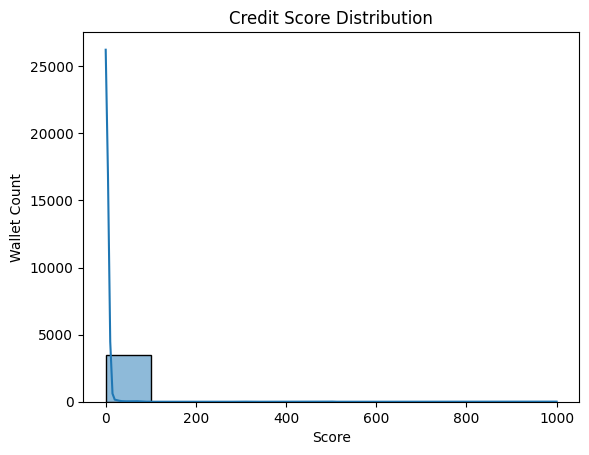

In [74]:
# Plot distribution of scores
sns.histplot(features['score'], bins=10, kde=True)
plt.title('Credit Score Distribution')
plt.xlabel('Score')
plt.ylabel('Wallet Count')
plt.show()


In [75]:
# Analyze low vs high score wallets
low_score_wallets = features[features['score'] < 200]
high_score_wallets = features[features['score'] > 800]

print("\nLow Score Wallet Behavior:\n", low_score_wallets.describe())
print("\nHigh Score Wallet Behavior:\n", high_score_wallets.describe())



Low Score Wallet Behavior:
           total_txn  num_deposit   num_borrow    num_repay    num_redeem  \
count   3491.000000  3491.000000  3491.000000  3491.000000   3491.000000   
mean      28.341449    10.708107     4.831280     3.551418      9.179605   
std      250.783846    29.585046    15.037714    13.325606    242.715710   
min        1.000000     0.000000     0.000000     0.000000      0.000000   
25%        1.000000     1.000000     0.000000     0.000000      0.000000   
50%        3.000000     2.000000     0.000000     0.000000      0.000000   
75%       16.000000     6.000000     3.000000     2.000000      3.000000   
max    14265.000000   511.000000   200.000000   291.000000  14265.000000   

       num_liquidation     total_usd  active_days     score_raw        score  
count      3491.000000  3.491000e+03  3491.000000  3.491000e+03  3491.000000  
mean          0.071040  1.498269e+23    22.548840  1.498269e+19     0.765110  
std           0.693478  1.399635e+24    33.136422